<a href="https://colab.research.google.com/github/JishnuJayaraj/ML/blob/master/NLP/_TrendDetection/TrendDetector25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/@satyajitghana7/how-to-upgrade-to-25gb-ram-in-google-colab-possibly-w-tesla-p100-gpu-for-free-115e7679f5de

!nvidia-smi
!lscpu | grep 'Model name'
!lscpu | grep 'Core(s) per socket'
!lscpu | grep 'Thread(s) per core'
# https://towardsdatascience.com/logging-with-weights-biases-da048e3cbc8b

# Tesla p100, Xeon 2,2
# 25gb RAM

Tue Oct 27 12:01:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loadding data

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive

# %matplotlib inline

pd.set_option('display.max_colwidth', None)

# df = pd.read_json('/content/Car_IoT_Cybersecurity.json')
# df = pd.read_json('/content/carIotcyberCorona.json')
df = pd.read_pickle('/content/drive/My Drive/RokinData/from2019.pkl')

df.drop_duplicates('title', inplace=True,)
df.dropna(subset=['title'], inplace=True)

df.info() # datetim obj necessary*

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97429 entries, 0 to 97428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    97429 non-null  datetime64[ns, UTC]
 1   title   97429 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 2.2+ MB


In [ ]:
# df.drop(['date','text','url','unknown'], axis=1, inplace=True)
# df.drop(['text','url','unknown'], axis=1, inplace=True)

In [ ]:
!pip install ipympl

In [ ]:
# check date column is datetime object, convert if needed
date_columns = df.select_dtypes(include=[np.datetime64])
print(list(date_columns))

# convert to date time
# df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
# df = df.dropna().reset_index(drop=True)
# df = df.query('date_new != "NaT"')

[]


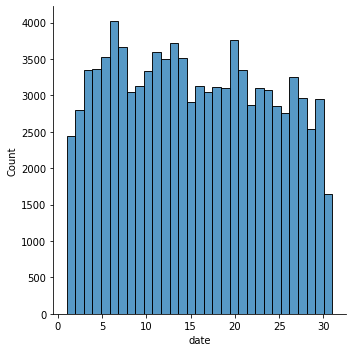

interactive(children=(Dropdown(description='x', options=('Y', '6M', '3M', '1M', '2W', '1W'), value='Y'), Outpu…

In [ ]:
# check if days and month were swaped (must be uniformly distributed plot)
import seaborn as sns
import matplotlib.pyplot as plt
days = df['date'].dt.day
sns.displot(days, kde= False, bins = 31)
plt.show()


# plot number of articles Yearwise
columns=['Y','6M','3M', '1M', '2W', '1W']
def g(x):
    df['date'].value_counts().resample(x).sum().plot.line()
    plt.show()
interactive_plot = interactive(g, x=columns)
interactive_plot


In [ ]:
# slice the date if needed
# df.query('date > "2015-06-01"', inplace=True)
df['date'] = df['date'].dt.tz_localize(None)
df.query('date > "2019-01-01" & date < "2020-04-01"', inplace=True)

# sort the index, 0 - n-1, and drop prev index
df.reset_index(drop=True, inplace=True)

## USE 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# sentence bert

# !pip install sentence-transformers
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# embeddings = model.encode(data, show_progress_bar=True)

In [ ]:
train_embeddings = model(df.title)

## Clustering

In [ ]:
!pip install hdbscan

import hdbscan
import numpy as np
# import matplotlib.pyplot as plt

# dim reduction
import umap

### dim reduction

In [ ]:
# clusterable_embedding = umap.UMAP(n_neighbors=10,
#     min_dist=0.0,
#     n_components=10,
#     random_state=42,
#     metric='cosine'
# ).fit_transform(train_embeddings)

clusterable_embedding = umap.UMAP(n_neighbors=3,min_dist=0.0,n_components=10,random_state=42,metric='cosine'
).fit_transform(train_embeddings)

In [ ]:
# plot the embedding

# !pip install umap-learn[plot]

# import umap.plot
# import pandas as pd
# import datashader as ds
# import datashader.transfer_functions as tf
# import datashader.bundling as bd
# import matplotlib.pyplot as plt
# import colorcet
# import matplotlib.colors
# import matplotlib.cm
# import bokeh.plotting as bpl
# import bokeh.transform as btr
# import holoviews as hv
# import holoviews.operation.datashader as hd

# umap.plot.points(clusterable_embedding) 
# labels = cluster values
# umap.plot.plt.show()

### Optimum parameter tuning

The optimum value of min_pts is :  5.0


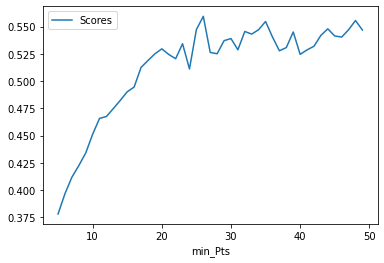

In [ ]:
# minimize the un clustered number usin probability
import numpy as np


scores = []
min_pts = []


# loop through min samples
for i in range(5,50):

  clusterer = hdbscan.HDBSCAN(min_samples=i)
  clusterer.fit(clusterable_embedding)
  
  all_prob = clusterer.probabilities_

  # Count odd numbers in the list
  count_niche = sum(map(lambda x : x <= 0.5, all_prob))

  # fraction with low confid
  score = count_niche/len(all_prob)

  scores.append(score)
  min_pts.append(i)


percentile_list = pd.DataFrame(np.column_stack([min_pts, scores]),columns=['min_Pts', 'Scores'])
index = percentile_list['Scores'].idxmin()
row = percentile_list.iloc[index]

print('The optimum value of min_pts is : ', row[0])
# plot score vs min pts
import matplotlib.pyplot as plt

# plt.plot(min_pts,scores)
percentile_list.plot(x='min_Pts', y='Scores', kind = 'line')

### run clustering

In [ ]:
#min_samples 10
clusterer = hdbscan.HDBSCAN(min_samples=40,min_cluster_size=50)

clusterer.fit(clusterable_embedding)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=40, p=None,
        prediction_data=False)

### data exploration

In [ ]:
# clusterer.labels_.max()
from collections import Counter
Counter(clusterer.labels_)

# clusterer.single_linkage_tree_.plot()

# island plot
# clusterer.condensed_tree_.plot()

Counter({-1: 35104,
         0: 59,
         1: 54,
         2: 69,
         3: 55,
         4: 64,
         5: 83,
         6: 103,
         7: 50,
         8: 137,
         9: 530,
         10: 51,
         11: 83,
         12: 942,
         13: 52,
         14: 241,
         15: 70,
         16: 71,
         17: 278,
         18: 117,
         19: 96,
         20: 58,
         21: 79,
         22: 169,
         23: 117,
         24: 173,
         25: 131,
         26: 113,
         27: 179,
         28: 54,
         29: 100,
         30: 54,
         31: 52,
         32: 63,
         33: 360,
         34: 73,
         35: 773,
         36: 75,
         37: 71,
         38: 55,
         39: 77,
         40: 50,
         41: 58,
         42: 52,
         43: 195,
         44: 54,
         45: 75,
         46: 56,
         47: 73,
         48: 116,
         49: 3303,
         50: 72,
         51: 207,
         52: 69,
         53: 259,
         54: 81,
         55: 52,
         56: 921

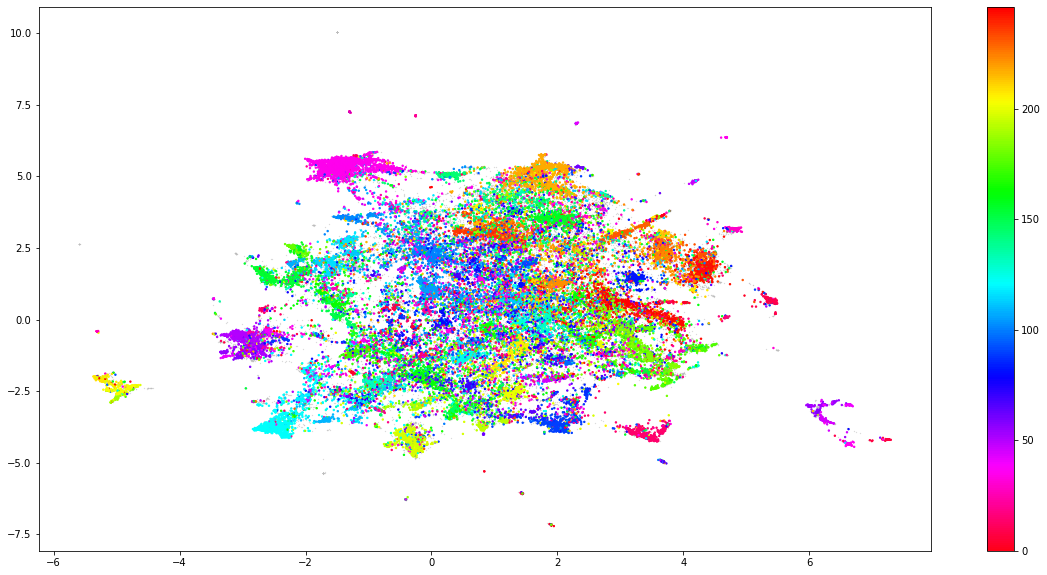

In [ ]:
#  plot the umap 2d
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(train_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusterer.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')
plt.colorbar()

## Append result to dataframe

In [ ]:
df.loc[:,'hdbscan_Clusters'] = None
df.loc[:,'hdbscan_Clusters'] = clusterer.labels_

In [ ]:
# ipywidget 
import ipywidgets as widgets

max_cluster = clusterer.labels_.max()
cluster_slider = widgets.IntSlider(value=5, max=max_cluster,description='Cluster no:')
display(cluster_slider)

# clusterer.labels_
# clusterer.probabilities_

IntSlider(value=5, description='Cluster no:', max=210)

In [ ]:
df.query('hdbscan_Clusters == @cluster_slider.value')

,date,title,hdbscan_Clusters
128,2019-09-27 00:00:00,Volkswagen Envisions New Beginnings for Old Batteries,196
760,2019-08-29 00:00:00,Infographic: How Green is Your EV? We Do the Math on Electric Cars.,196
1654,2019-07-12 00:00:00,"Volkswagen invests $2.6B in Argo AI for self-driving cars, expands pact with Ford",196
2881,2019-06-19 00:00:00,Driving the new era of electric powertrain development,196
3290,2019-05-08 00:00:00,New high voltage automotive connector launched,196
3328,2019-05-14 00:00:00,Volkswagen relies on Infineon for its electric future,196
4149,2019-10-28 00:00:00,Bringing listening pleasure to the VW experience,196
4885,2019-07-10 00:00:00,EV prototype drive prepares for launch of U5,196
5713,2019-04-26 00:00:00,Features Factory Ford to invest $500M in electric vehicle startup Rivian,196
5721,2019-05-14 00:00:00,Features Factory Volkswagen to invest 1B euros in battery production plant,196
